<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install dtw-python

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import math
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from dtw import *

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [4]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
def print_serie(serie_,title_,ytitle_,xtitle_,dot_,namefile_):
    fig, ax1 = plt.subplots(figsize=(7,4))
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel(xtitle_, color=LETRASNARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=LETRASNARA, fontsize='large')
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)    
    for p in serie_:
        if dot_== True:
           plt.plot(p,alpha=0.4, linestyle='dashed', linewidth=3)
        else:
           plt.plot(p,alpha=0.4)                
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [5]:
## Encuentra los vecinos más cercanos
def get_neighbors(train, test_row, num_neighbors, typedist='euclidean'):
  
    distances = list()

    for train_row in train:
        if typedist == 'dtw':
            dist = dtw(test_row, train_row)
        else:
            dist = euclidean(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])

    neighbors = list()

    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

## Calcula distancia euclidiana
def euclidean(neig1, neig2):
	  distance = 0.0
	  for i in range(len(neig1)):
		    distance += (neig1[i] - neig2[i])**2
	  return sqrt(distance)

In [6]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path        = 'https://drive.google.com/uc?export=download&id=' 
URL_Demanda = 'https://drive.google.com/file/d/1xcpXDTE7H6EBMLOkic5lq-lzSwiLG2ZS/view?usp=sharing'
df_Demanda  = pd.read_csv(path + URL_Demanda .split('/')[-2], usecols=[0] ) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,], 1,2,3,4,5,6,7,8,9,10,11,12,13,15,
df_Demanda.dropna(inplace=True)
serie = df_Demanda.to_numpy()
serie = StandardScaler().fit_transform(serie)
serie =serie.ravel()

In [7]:
def analogo_knn(serie,v,k=10,tol=0.8,typedist='euclidian',typereg='OLS'):    
#    v       : tamanio de la ventana
#    k       : número de vecinos a buscar k
#    tol     : tolerancia de tamaño de ventanas para seleccion de vecinos
#    typedist: medida de distancia, 'dtw' o 'euclidian' o 'pearson'
    t_o = time.time() 
    vecindario    = []         ## vecindario completo
    vecindario_b  = [] 
    distances     = []
    n             = len(serie) ## longitud total de la serie

    ## PASO 1: Selección de las ventanas de mayor correlación.

    ## Se calcula la distancia entre todos los vecinos.

    Y = serie[n-v:n]           ## últimos datos
    for i in range(n-2*v):
        if  typedist == 'dtw': ## dynamic time warping
            dist = dtw(Y, serie[i:i+v]).distance  
        elif typedist == 'pearson':
            dist = np.corrcoef(Y,serie[i:i+v])[1,0]
        else:
            dist = euclidean(Y,serie[i:i+v])
        if dist > 0:
            distances.append((i, dist))
        
    ## Se ordena el vecindario por distancia de menor a mayor y se guardan las posiciones.
    if typedist == 'pearson':
        ## En caso de pearson se ordena al revés, nos interesan los mayor correlación.
        distances.sort(key=lambda tup: tup[1], reverse=True)
    else:
        ## En caso de pearson se ordena al revés, nos interesan los de menor distancia.
        distances.sort(key=lambda tup: tup[1], reverse=False)

    neighbors  = []
    neighbors2 = []
    position   = []

    ## Se escogen los k vecinos mas cercanos y guardamos las posiciones.
    i = 0
    for pos, dis in distances:
        if i==0:      
            position.append(pos)   
            neighbors.append(serie[pos:pos+v])
            neighbors2.append(serie[pos+v:pos+2*v])
        else:
            bandera = True
            for p in position:
                 ## si ya teniamos una posición en la lista que pase la tolerancia, ya no guardamos 
                if (abs(pos - p) < tol*v):
                    bandera = False
                    i = i - 1
                    break
            if bandera == True:
                ## Guarda nuevo vecino
                position.append(pos)   
                neighbors.append(serie[pos:pos+v])
                neighbors2.append(serie[pos+v:pos+2*v])
                bandera = False
        i = i + 1
        if i == k:
            break
    print('position KNN:',position)    ## posición de los k vecinos mas cercanos

    ## Convertimos a numpy
    neighbors  = np.array(neighbors)
    neighbors2 = np.array(neighbors2)

    print_serie(neighbors, 'KNN - X         ','','time', False,'fig_1')
    print_serie(neighbors2,'KNN - X2 (prima)','','time', False,'fig_2')

    t_sel = time.time() - t_o

    ## PASO 2: Regresión entre los vecinos mas cercanos 'X' y la última ventana 'Y'

    ## definimos nuestros regresores 
    X   = (neighbors.T).tolist()
    X_2 = (neighbors2.T).tolist()
    Y   = (Y).tolist()

    ## Regresión -- OLS with Stepwise --
    if typereg == 'OLS':
        model   = sm.OLS(Y, X)
        results = model.fit()
        result_prediction = results.predict(X_2)

        ## Se ordenan los valores 'pi' y se selecciona el más grande.
        i = 0
        pvalues = []
        for pi in results.pvalues:
            pvalues.append((i,pi))
            i = i + 1
        pvalues.sort(key=lambda tup: tup[1], reverse=True) ## ordena por 'pi'
        print(pvalues)
        (i, pi) = pvalues[0]  
        print('pi_0:',pi)

        while pi > 0.05:
            X   = sm.add_constant(X)
            X_2 = sm.add_constant(X_2) 
            print('Retiramos regresor X' + str(i))
            X   = np.delete(arr=X,   obj=i+0, axis=1)
            X_2 = np.delete(arr=X_2, obj=i+0, axis=1)   
            model   = sm.OLS(Y, X)
            results = model.fit()

            ## Se ordenan los valores 'pi' y se selecciona el más grande
            i = 0
            pvalues = []
            for pi in results.pvalues:
                pvalues.append((i,pi))
                i = i + 1
            pvalues.sort(key=lambda tup: tup[1], reverse=True) ## ordena por 'pi'
            (i, pi) = pvalues[0]
            print('pi',i,':',pi)
            #prediction   = results.predict(X)   ## Ajuste
            prediction_Y2 = results.predict(X_2) ## Pronóstico
        #print(results.summary())

    ## Regresión -- Random Forrest Regression --
    #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
    if typereg == 'RF':
        model   = RandomForestRegressor(max_depth=2, random_state=0)
        results = model.fit(X, Y)
        prediction_Y2 = results.predict(X_2)

    t_reg = time.time() - t_sel  

    return prediction_Y2, t_sel, t_reg

---

## Probamos el modelo con 'pearson' y 'RF'.



In [8]:
## Parámetros de prueba.
v=288; k=25 ; tol=0.8; n_test = 1 * v;

position KNN: [24197, 21892, 22179, 10082, 20164, 20740, 18725, 22467, 18150, 24485, 19876, 12098, 20451, 18433, 13830, 24768, 14116, 2017, 11809, 22754, 6050, 8642, 5761, 3742, 17862]


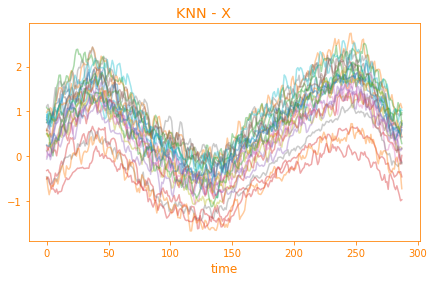

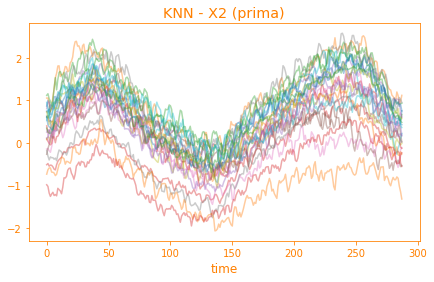

tiempo de selección: 5.591736316680908
tiempo de regresión 1651962705.9538636


In [9]:
## PROBAMOS EL MODELO con la última ventana
if 1==1:
    x_train = serie[0 : len(serie) - n_test]
    y_test  = serie[len(serie) - n_test : ]
    pred_pea_rf, t_sel_pea_rf, t_reg_pea_rf = analogo_knn(x_train,v=v,k=k,tol=tol,typedist='pearson',typereg='RF')
    print('tiempo de selección:',t_sel_pea_rf)
    print('tiempo de regresión', t_reg_pea_rf)

    # Exactitud del modelo
    mae_pea_rf = mean_absolute_error(y_test,pred_pea_rf)
    mape_pea_rf = mean_absolute_percentage_error(y_test,pred_pea_rf)

---
## Probamos el modelo con 'pearson' y 'OLS'.

position KNN: [24197, 21892, 22179, 10082, 20164, 20740, 18725, 22467, 18150, 24485, 19876, 12098, 20451, 18433, 13830, 24768, 14116, 2017, 11809, 22754, 6050, 8642, 5761, 3742, 17862]


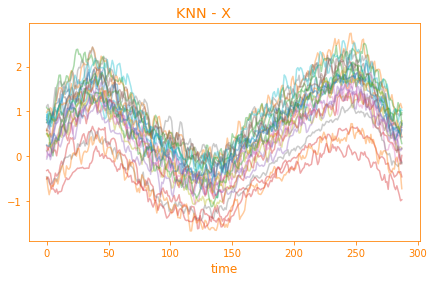

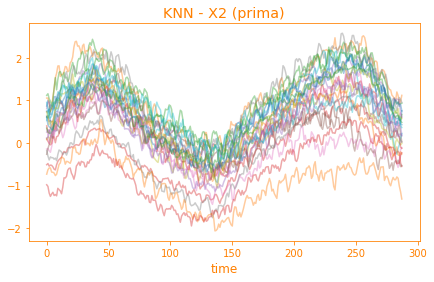

[(12, 0.9333036397271803), (20, 0.9102719190592549), (8, 0.8753369189061408), (13, 0.8469725761094917), (22, 0.8166936689251212), (4, 0.6807769950028432), (3, 0.5435884869063039), (9, 0.5123558692780148), (14, 0.5096887001797261), (23, 0.4531380731041984), (21, 0.4295167324195458), (6, 0.42098739269524665), (1, 0.357801128046792), (18, 0.3237299018663452), (5, 0.2090109107276811), (10, 0.19404144540954404), (16, 0.06434636696661769), (17, 0.05560083040334403), (19, 0.032180711516248246), (11, 0.02542467280377989), (7, 0.008762604494217665), (24, 0.005000530577377466), (2, 0.004058136267776216), (15, 1.4804106657877618e-05), (0, 6.211121145934467e-08)]
pi_0: 0.9333036397271803
Retiramos regresor X12
pi 9 : 0.9790313437734346
Retiramos regresor X9
pi 21 : 0.9540882920153579
Retiramos regresor X21
pi 11 : 0.9169442015261535
Retiramos regresor X11
pi 0 : 0.8405878400584743
Retiramos regresor X0
pi 17 : 0.8818192644298736
Retiramos regresor X17
pi 4 : 0.9591615837522126
Retiramos regresor X

In [10]:
## PROBAMOS EL MODELO con la última ventana
if 1==1:
    x_train = serie[0 : len(serie) - n_test]
    y_test  = serie[len(serie) - n_test : ]
    pred_pea_ols, t_sel_pea_ols, t_reg_pea_ols = analogo_knn(x_train,v=v,k=k,tol=tol,typedist='pearson',typereg='OLS')
    print('tiempo de selección:',t_sel_pea_ols)
    print('tiempo de regresión', t_reg_pea_ols)

    # Exactitud del modelo
    mae_pea_ols  = mean_absolute_error(y_test,pred_pea_ols)    
    mape_pea_ols = mean_absolute_percentage_error(y_test,pred_pea_ols)



---



## Probamos el modelo con 'euclidian' y 'OLS' 

position KNN: [22179, 20740, 22467, 21892, 22754, 23912, 24197, 20451, 24768, 24485, 19876, 6623, 12098, 6336, 20165, 6051, 23620, 11814, 5761, 13829, 23047, 21604, 14117, 14403, 14690]


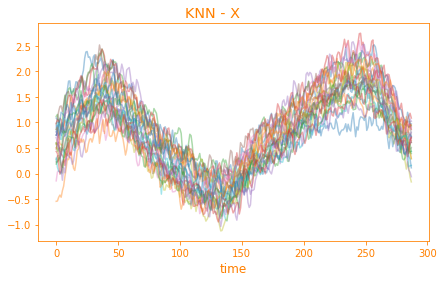

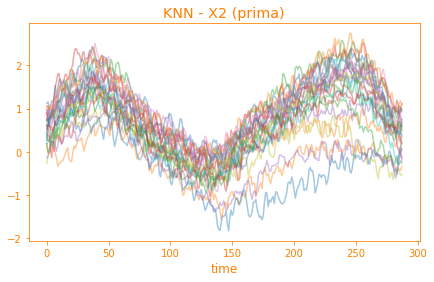

[(14, 0.954181139558095), (9, 0.9106479461433591), (1, 0.8363863138314607), (3, 0.7114636015309808), (7, 0.6514840301275535), (17, 0.6250030427019546), (5, 0.6216421400231387), (18, 0.2598328570862594), (23, 0.21316400588270432), (22, 0.169172815629923), (10, 0.16405134545253536), (19, 0.16005234609804778), (21, 0.15590356866437663), (2, 0.13861407735897227), (20, 0.0915406773631622), (15, 0.07722894689962079), (11, 0.0640041091178207), (16, 0.061651774141234336), (13, 0.04353605980232737), (4, 0.025022409372001255), (12, 0.013181026593886095), (24, 0.006603078205674), (0, 0.003462481382831337), (8, 2.0805655193515546e-07), (6, 7.107864864136676e-09)]
pi_0: 0.954181139558095
Retiramos regresor X14
pi 2 : 0.6852850697363221
Retiramos regresor X2
pi 9 : 0.662340855997876
Retiramos regresor X9
pi 12 : 0.67407049695131
Retiramos regresor X12
pi 9 : 0.5642199487802452
Retiramos regresor X9
pi 5 : 0.32066351956356814
Retiramos regresor X5
pi 13 : 0.24896185905534443
Retiramos regresor X13
pi

In [11]:
## PROBAMOS EL MODELO con la última ventana
if 1==1:
    x_train = serie[0 : len(serie) - n_test]
    y_test  = serie[len(serie) - n_test : ]
    pred_euc_ols, t_sel_euc_ols, t_reg_euc_ols = analogo_knn(x_train,v=v,k=k,tol=tol,typedist='euclidian',typereg='OLS')
    print('tiempo de selección:',t_sel_euc_ols)
    print('tiempo de regresión:',t_reg_euc_ols)

    # Exactitud del modelo
    mae_euc_ols = mean_absolute_error(y_test,pred_euc_ols)
    mape_euc_ols = mean_absolute_percentage_error(y_test,pred_euc_ols)

---

## Probamos el modelo con 'euclidian' y 'RF'.



position KNN: [22179, 20740, 22467, 21892, 22754, 23912, 24197, 20451, 24768, 24485, 19876, 6623, 12098, 6336, 20165, 6051, 23620, 11814, 5761, 13829, 23047, 21604, 14117, 14403, 14690]


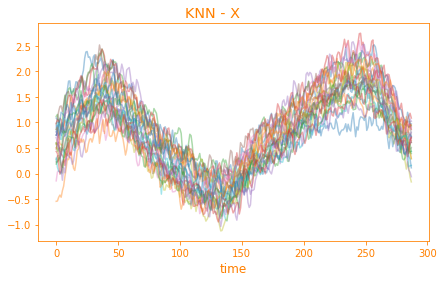

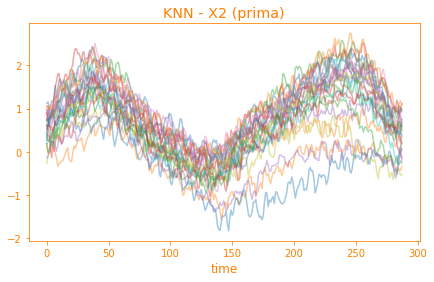

tiempo de selección: 7.286769866943359
tiempo de regresión: 1651962733.2196198


In [12]:
## PROBAMOS EL MODELO con la última ventana
if 1==1:
    x_train = serie[0 : len(serie) - n_test]
    y_test  = serie[len(serie) - n_test : ]
    pred_euc_rf, t_sel_euc_rf, t_reg_euc_rf = analogo_knn(x_train,v=v,k=k,tol=tol,typedist='euclidian',typereg='RF')
    print('tiempo de selección:',t_sel_euc_rf)
    print('tiempo de regresión:',t_reg_euc_rf)

    # Exactitud del modelo
    mae_euc_rf = mean_absolute_error(y_test,pred_euc_rf)
    mape_euc_rf = mean_absolute_percentage_error(y_test,pred_euc_rf)

---

## Probamos el modelo con 'dtw' y 'OLS'.

position KNN: [22757, 20745, 22184, 24781, 21896, 22469, 23904, 24193, 20453, 24485, 19881, 12106, 6345, 5773, 20163, 11815, 6640, 6061, 23625, 13836, 14128, 14424, 23048, 21611, 2621]


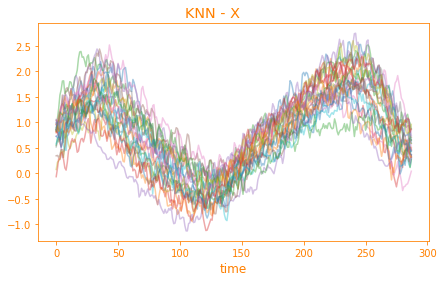

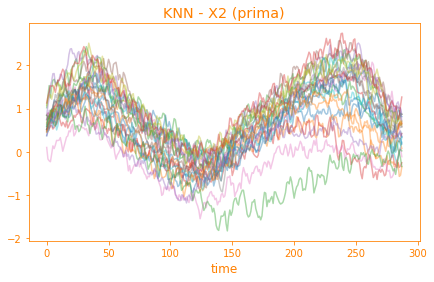

[(18, 0.661241314891883), (10, 0.5030881802488265), (2, 0.41857960836392527), (14, 0.3908119318694435), (12, 0.27260492011576815), (15, 0.2005489729038747), (6, 0.19651399052956608), (22, 0.14796406563941125), (23, 0.10682790544848886), (11, 0.08858812540468691), (21, 0.07836823643676322), (7, 0.07494597803435239), (20, 0.034964757607718375), (3, 0.030788797925300794), (16, 0.017027375781599418), (4, 0.008597667822807104), (8, 0.00793509381074478), (9, 0.002938853309062486), (0, 0.002618005696992427), (17, 0.0025104452545195626), (5, 0.0011304249884736973), (1, 5.0741789009856644e-05), (24, 2.5096882426711856e-05), (19, 3.284962373428546e-06), (13, 4.900921544576075e-07)]
pi_0: 0.661241314891883
Retiramos regresor X18
pi 3 : 0.653953133888328
Retiramos regresor X3
pi 10 : 0.6728773245470281
Retiramos regresor X10
pi 14 : 0.6105454267863684
Retiramos regresor X14
pi 15 : 0.36353772106475113
Retiramos regresor X15
pi 19 : 0.38626993438087665
Retiramos regresor X19
pi 13 : 0.2383828605807

In [13]:
## PROBAMOS EL MODELO con la última ventana
if 1==1:
    x_train = serie[0 : len(serie) - n_test]
    y_test  = serie[len(serie) - n_test : ]
    pred_dtw_ols, t_sel_dtw_ols, t_reg_dtw_ols = analogo_knn(x_train,v=v,k=k,tol=tol,typedist='dtw',typereg='OLS')
    print('tiempo de selección:',t_sel_dtw_ols)
    print('tiempo de regresión', t_reg_dtw_ols)

    # Exactitud del modelo
    mae_dtw_ols = mean_absolute_error(y_test,pred_dtw_ols)
    mape_dtw_ols = mean_absolute_percentage_error(y_test,pred_dtw_ols)

---

## Probamos el modelo con 'dtw' y 'RF'.

position KNN: [22757, 20745, 22184, 24781, 21896, 22469, 23904, 24193, 20453, 24485, 19881, 12106, 6345, 5773, 20163, 11815, 6640, 6061, 23625, 13836, 14128, 14424, 23048, 21611, 2621]


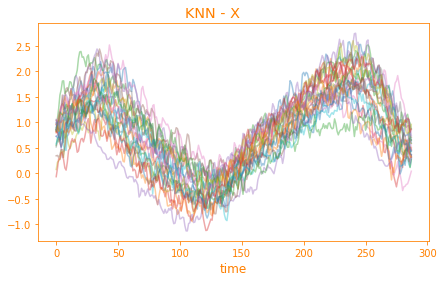

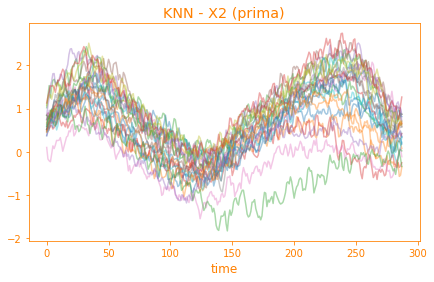

tiempo de selección: 181.71161723136902
tiempo de regresión 1651962936.2478445


In [14]:
## PROBAMOS EL MODELO con la última ventana
if 1==1:
    x_train = serie[0 : len(serie) - n_test]
    y_test  = serie[len(serie) - n_test : ]
    pred_dtw_rf, t_sel_dtw_rf, t_reg_dtw_rf = analogo_knn(x_train,v=v,k=k,tol=tol,typedist='dtw',typereg='RF')
    print('tiempo de selección:',t_sel_dtw_rf)
    print('tiempo de regresión', t_reg_dtw_rf)

    # Exactitud del modelo
    mae_dtw_rf = mean_absolute_error(y_test,pred_dtw_rf)
    mape_dtw_rf = mean_absolute_percentage_error(y_test,pred_dtw_rf)

---

## Comparamos graficamente los resultados



In [15]:
print('| SELECCIÓN      | REGRESIÓN      | MAE             | MAPE             | TIEMPO SELECCIÓN     | TIEMPO REGRESIÓN   |')
print('| :------------- | :------------- | -------------:  | -------------:   |-------------:        |-------------:        |')
print('| PEARSON        | OLS + STEP     |',str(trunc(mae_pea_ols,4)),'         |',str(trunc(mape_pea_ols,4)),'         |',str(trunc(t_sel_pea_ols,4)),'              |   ',str(trunc(t_reg_pea_ols,4)),     '|')
print('| EUCLIDIAN      | OLS + STEP     |',str(trunc(mae_euc_ols,4)),'         |',str(trunc(mape_euc_ols,4)),'         |',str(trunc(t_sel_euc_ols,4)),'             |   ',str(trunc(t_reg_euc_ols,4)),    '|')
print('| DTW            | OLS + STEP     |',str(trunc(mae_dtw_ols,4)),'         |',str(trunc(mape_dtw_ols,4)),'         |',str(trunc(t_sel_dtw_ols,4)),'            |   ',str(trunc(t_reg_dtw_ols,4)),    '|')
print('| PEARSON        | RF             |',str(trunc(mae_pea_rf,4)),'         |',str(trunc(mape_pea_rf,4)),'          |',str(trunc(t_sel_pea_rf,4)),'              |   ',str(trunc(t_reg_pea_rf,4)),    '|')
print('| EUCLIDIAN      | RF             |',str(trunc(mae_euc_rf,4)),'          |',str(trunc(mape_euc_rf,4)),'         |',str(trunc(t_sel_euc_rf,4)),'              |   ',str(trunc(t_reg_euc_rf,4)),     ' |')
print('| DTW            | RF             |',str(trunc(mae_dtw_rf,4)),'         |',str(trunc(mape_dtw_rf,4)),'          |',str(trunc(t_sel_dtw_rf,4)),'            |   ',str(trunc(t_reg_dtw_rf,4)),    '|')

| SELECCIÓN      | REGRESIÓN      | MAE             | MAPE             | TIEMPO SELECCIÓN     | TIEMPO REGRESIÓN   |
| :------------- | :------------- | -------------:  | -------------:   |-------------:        |-------------:        |
| PEARSON        | OLS + STEP     | 0.3641          | 19.4695          | 8.3167               |    1651962711.8578 |
| EUCLIDIAN      | OLS + STEP     | 0.3373          | 24.2788          | 12.6475              |    1651962720.3151 |
| DTW            | OLS + STEP     | 0.4591          | 19.4118          | 195.4019             |    1651962740.6027 |
| PEARSON        | RF             | 0.3567          | 12.2111           | 5.5917               |    1651962705.9538 |
| EUCLIDIAN      | RF             | 0.3928           | 10.561          | 7.2867               |    1651962733.2196  |
| DTW            | RF             | 0.4059          | 5.1296           | 181.7116             |    1651962936.2478 |


No handles with labels found to put in legend.


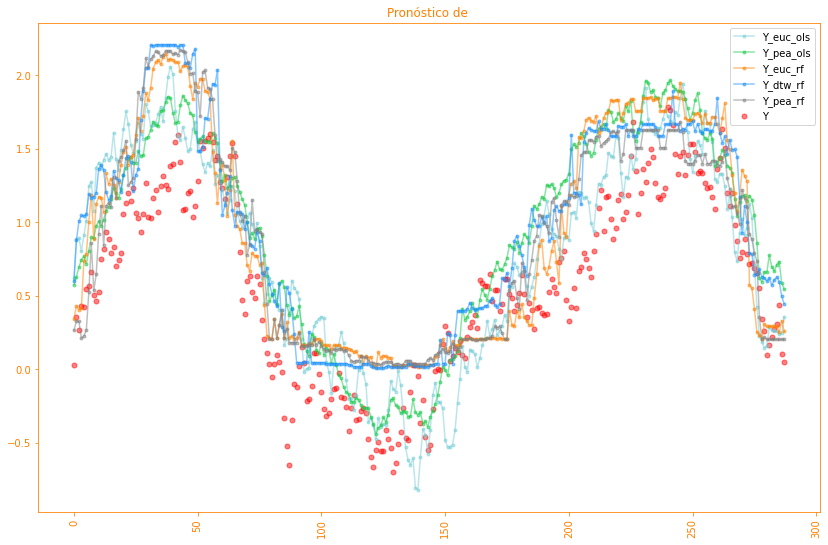

No handles with labels found to put in legend.


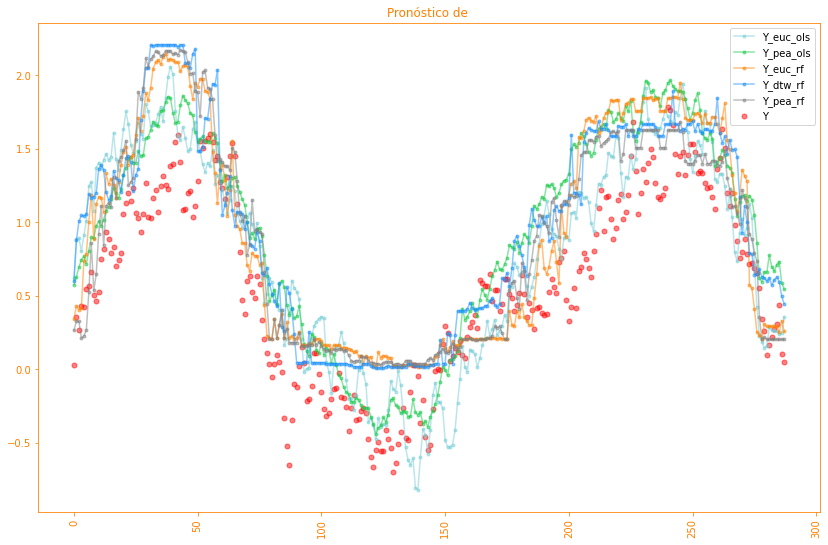

In [18]:
fig  = plt.figure(figsize=(14,9))
axes = fig.add_subplot(1, 1, 1)
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; NARA ='#ff8000'; AZUL='#168fff'; GRIS = '#808080'
mytitle = plt.title('Pronóstico de ') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color=LETRASNARA) #set the color of title to red
axes.xaxis.label.set_color(LETRASNARA)
axes.yaxis.label.set_color(LETRASNARA)
axes.tick_params(colors=LETRASNARA, which='both')

AUX = np.arange( len(y_test) )
#plt.scatter( dfx_miss, dfy_miss, marker='x',  s=170 ,  color = 'red' , label = 'perdidos' ,alpha=1)
plt.scatter ( AUX, y_test, s=25,marker='o', color = 'red', label = 'Y', alpha=1/2)
#axes.plot   ( y_test ,      '.-', color = 'red' , label = 'Y',         alpha=1/4)
axes.plot   ( pred_euc_ols, '.-', color = CYAN  , label = 'Y_euc_ols', alpha=1/2)
#axes.plot   ( pred_dtw_ols, '.-', color = LILA  , label = 'Y_dtw_ols', alpha=1/2)
axes.plot   ( pred_pea_ols, '.-', color = VERDE , label = 'Y_pea_ols', alpha=1/2)
axes.plot   ( pred_euc_rf, '.-',  color = NARA  , label = 'Y_euc_rf', alpha=1/2)
axes.plot   ( pred_dtw_rf, '.-',  color = AZUL  , label = 'Y_dtw_rf', alpha=1/2)
axes.plot   ( pred_pea_rf,  '.-', color = GRIS  , label = 'Y_pea_rf' , alpha=1/2)
#axes.plot  ( xspline[3], yspline[3] , '.-'  , color = VERDE   , label = 'orden=4'  ,alpha=1/2)

#plt.axis([0,  600, 7650, 9800])
#plt.axis([100,  200, 7650, 9500])
#plt.axis([400,  500, 7450, 9500])
#plt.axis([-2,  100, 8100, 9600])
#plt.axis([300, 400, 7900, 9500])

axes.spines['bottom'].set_color(LETRASNARA)
axes.spines['top'   ].set_color(LETRASNARA) 
axes.spines['right' ].set_color(LETRASNARA)
axes.spines['left'  ].set_color(LETRASNARA)
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('fig_t15_ajuste_prono.png', transparent=True)
plt.show()